In [1]:
import numpy as np
def dde_solve(ddes, state_vars, delayed_vars, histories, tmax, timestep, **options):
    """Numerically integrates a system of DDEs using 4th-order Runge-Kutta

    A delay differential equation is a (system of) equation(s) of the form 
        X'(t) = f(X, Y, ... , X_tau1, X_tau2, ... , Y_tau1, ... )

        Y'(t) = g(X, Y, ... , X_tau1, X_tau2, ... , Y_tau1, ... )

    where on the right hand side X denotes X(t) and each X_tau denotes 
    X(t - tau) for some constant delay tau, and likewise for Y and Y_tau. 

    INPUTS:

    - ``ddes`` - A list/tuple of Sagemath symbolic expressions that are the 
      right-hand-side of each delay differential equation

    - ``state_vars`` - A list/tuple of the state variables to use

    - ``delayed_vars`` - A dictionary whose keys are the symbolic variables 
      that represent delayed variables in the DDE expressions, and whose 
      values are 2-tuples consisting of the corresponding state variable and 
      the length of the delay. For example, for the delayed Lotka-Volterra 
      system 
      ::
        N'(t) = N(t) - N(t) P(t)
        P'(t) = N(t - 5) P(t) - P(t)
      the ``ddes`` argument might be written as 
        (N - N * P, Ntau * P - P)
      in which case the ``delayed_vars`` argument would be 
        {Ntau: (N, 5)}
      You can read this as ``Ntau represents N delayed by 5``. Note this 
      means that before calling this function, all three of `N`, `P`, 
      and `Ntau` should have been declared as symbolic variables: 
        var("N, P, Ntau")

    - ``histories`` - A list/tuple of functions or Sagemath expressions giving 
      the history of each state variable, as a function of ``t`` (time)

    - ``tmax`` - Integrate from t = 0 to this time

    - ``timestep`` - The size of each time step (the smaller, the more 
      accurate)

    OPTIONS:

    - ``t_var`` - The variable to use for time in the history functions. 
      Defaults to ``t``. 

    - ``starting_t`` - The starting value of t to use. Defaults to 0. 

    OUTPUT:

    An array with one column for the t values, and one column for each of the 
    state variables, in the order they were specified. The output array will 
    of course have one row for each time step, from t = 0 (or t = 
    ``starting_t`` if specified) to t = ``tmax``. 

    Note that having the t-values included in the first column of the output 
    is for convenience, so that one can plot time series, trajectories, etc, 
    without having to use ``zip`` or ``numpy.insert``. See the examples below. 

    EXAMPLES:

    A version of Mackey-Glass, using a constant 0 history::

        var("X, X_t")
        solution = dde_solve(1 - X * X_t^5 / (1 + X_t^5), X, {X_t: (X, 8)}, history=0, tmax=400, timestep=0.1)
        list_plot(solution, plotjoined=True)

    The same, but with an oscillating history function, giving weird 
    transients that give way to a periodic steady state::

        var("t, X, X_tau")
        eq = 1 - X * X_tau^5 / (1 + X_tau^5)
        solution = dde_solve(eq, X, {X_tau: (X, 8)}, 5*cos(t), 400, 0.1)
        list_plot(solution, plotjoined=True)

    HPG model, replacing the P with a delayed H::

        var("H, G, H_tau")
        ddes = (
            1 / (1 + G^n) - 0.2*H, 
            H_tau - 0.2*G, 
        )
        delayed_vars = {H_tau: (H, 0.7)}
        solution = dde_solve(ddes, (H, G), delayed_vars, (1, 1), 100, 0.01)
        list_plot(solution[:,(0,1)], plotjoined=True) # Plot the H time series
        list_plot(solution[:,(0,2)], plotjoined=True) # Plot the G time series
        list_plot(solution[:,(1,2)], plotjoined=True) # Plot a trajectory
    """

    # Check validity of delays. 
    if any([delay < 0 for dvar, delay in delayed_vars.values()]):
        raise ValueError("This function will not work with negative delays. "
            "Consider consulting a fortune teller instead.")

    # Deal with extra options
    starting_t = options.get("starting_t", 0)
    t_var = options.get("t_var", "t")

    # If they gave a single DDE, convert it to a system
    if isinstance(state_vars, sage.symbolic.expression.Expression):
        ddes = [ddes]
        state_vars = [state_vars]
        histories = [histories]

    # Set up for history lookups
    delayed_vars = delayed_vars.items()
    ddes = [dde.subs({dv: sv for dv, (sv, delay) in delayed_vars if delay == 0}) for dde in ddes]
    delayed_vars = [(dv, (sv, delay)) for dv, (sv, delay) in delayed_vars if delay != 0]
    all_vars = set().union(*[dde.variables() for dde in ddes])
    actual_delays = set([delay for dv, (sv, delay) in delayed_vars if dv in all_vars])
    delays = []
    all_vars = list(state_vars)
    for this_delay in sorted(actual_delays):
        delays.append((this_delay, [state_vars.index(sv) for dv, (sv, delay) in delayed_vars if delay == this_delay]))
        all_vars.extend([dv for dv, (sv, delay) in delayed_vars if delay == this_delay])
    ddes = [fast_float(dde, *all_vars) for dde in ddes]
    histories = [fast_float(history, t_var) for history in histories]
    num_state_vars = len(state_vars)

    # Adjust the timestep if necessary
    if delays:
        timestepcorrectionfactor = ceil(timestep / delays[0][0] * 2)
    else:
        timestepcorrectionfactor = 1
    timestep /= timestepcorrectionfactor

    # Initialize the solver
    t = starting_t
    state = np.array([history(t) for history in histories])
    t_values = [t]
    solution = [state]
    var_values = np.zeros(len(all_vars), dtype=float)

    # The function that performs a complete history lookup
    def lookup(t):
        """Does a history lookup at each delay from t, stores result in var_values[num_state_vars:]"""
        i = num_state_vars
        for delay, indices in delays:
            next_i = i + len(indices)
            t0 = t - delay
            if t0 <= starting_t:
                var_values[i:next_i] = [histories[j](t0) for j in indices]
            else:
                r = t0 / timestep
                n = floor(r) # Sagemath correctly returns an *int* here, not a float!
                r -= n
                var_values[i:next_i] = (solution[n]*(1 - r) + solution[n + 1]*r)[indices]
            i = next_i

    # Set up for the first iteration...
    lookup(t)
    # ...and iterate!
    while t < tmax:
        # Compute k1. Note history lookup has already been done. 
        var_values[:num_state_vars] = state
        k1 = np.array([dde(*var_values) for dde in ddes])
        # Compute k2. 
        var_values[:num_state_vars] += timestep/2 * k1
        lookup(t + timestep/2)
        k2 = np.array([dde(*var_values) for dde in ddes])
        # Compute k3. Note history lookup has already been done. 
        var_values[:num_state_vars] = state + timestep/2 * k2
        k3 = np.array([dde(*var_values) for dde in ddes])
        # Compute k4. 
        var_values[:num_state_vars] = state + timestep * k3
        lookup(t + timestep)
        k4 = np.array([dde(*var_values) for dde in ddes])
        # Finally, compute the RK4 weighted average. 
        t += timestep
        state = state + (k1 + 2*k2 + 2*k3 + k4)/6 * timestep # Do not use += here, to force a copy!
        t_values.append(t)
        solution.append(state)
    solution = np.array(solution)
    return np.insert(solution, 0, t_values, axis=1)[::timestepcorrectionfactor]


**The Mackey–Glass model of CO$_2$ ventilation**

Let $X(t) = $ the concentration of CO$_2$ in the blood *at the lungs*. 

So $X(t - \tau) = $ the concentration of CO$_2$ in the blood *at the brainstem*. 

Assumptions:
 - The person is resting, so the rate of increase of CO$_2$ in the blood (due to
the body’s metabolic processes) is a constant: 6 $\frac{\text{mEq}}{\text{L}}$ per minute. 
 - Since CO$_2$ passes from the blood into the air in the alveoli by osmosis, the amount of CO$_2$ exhaled per breath is proportional to the concentration of CO$_2$ in the blood at the lungs: $X(t)$. Use a proportionality constant of 1. 
 - The breathing rate is set based on the concentration of CO$_2$ at the brainstem: when the CO$_2$ level is low, the breathing rate is lower; when the CO$_2$ level is high, the breathing rate is higher, but only up to a maximum of $16$ breaths per minute. Use a sigmoid function for this. 
 - Since it takes about $0.2$ minutes for blood to travel from the lungs to the brainstem, the previous assumption occurs with a time delay of 0.2. 


In [2]:
X = var("X")
@interact
def steepness(n=slider(2, 20, 1, default=2, label="$n$"), show_max=False):
    v_max = 80
    p = plot(v_max * X^n/(1 + X^n), (X, 0, 3), thickness=2)
    if show_max:
        p += line(((0, v_max), (3, v_max)), color="red", linestyle="dashed")
    p.show(ymax=1.5*v_max, axes_labels=(r"$X(t - \tau)$", "Breathing rate"))

Interactive function <function steepness at 0x7f57393549d8> with 2 widgets
  n: TransformIntSlider(value=2, de…

In [3]:
@interact(n=slider(1, 10, 1, default=2, label=r"$n$ (steepness)"), 
          delay=slider(0, 0.9, 0.02, default=0.1, label=r"$\tau$ (delay)"), 
          tmax=slider([4, 10, 20, 50], label=r"$t_{max}$"))
def co2_ventilation(n, delay, tmax):
    X, X_tau = var("X, X_tau")
    l = 6
    v_max = 80
    a = 0.2
    history = 4
    timestep = 0.01
    diffeq = l - v_max * X_tau^n/(1 + X_tau^n) * a*X
    label = r"$X'(t) = %d - %d X(t) \cdot \frac{X(t - %.02f)^{%d}}{1 + X(t - %.02f)^{%d}}$"
    label = label % (l, a*v_max, delay, n, delay, n)

    solution = dde_solve(diffeq, X, {X_tau: (X, delay)}, history, tmax, timestep)
    p = list_plot(solution, plotjoined=True)
    p += text(label, (tmax/2, 5), color="black", fontsize=20)
    p.show(ymin=0, ymax=6, axes_labels=("$t$", "$X$"))


Interactive function <function co2_ventilation at 0x7f5735dcd488> with 3 widgets
  n: TransformIntSlider(value…

In [4]:
@interact(n=slider(1, 10, 1, default=2, label=r"$n$ (steepness)"), 
          delay=slider(0, 0.9, 0.02, default=0.1, label=r"$\tau$ (delay)"), 
          tmax=slider([4, 10, 20, 50], label=r"$t_{max}$"))
def co2_ventilation_sigmoid(n, delay, tmax):
    X, X_tau = var("X, X_tau")
    l = 6
    v_max = 80
    a = 0.2
    history = 4
    timestep = 0.01
    sigmoid = v_max * X_tau^n/(1 + X_tau^n)
    diffeq = l - sigmoid * a*X
    label = r"$X'(t) = %d - %d X(t) \cdot \frac{X(t - %.02f)^{%d}}{1 + X(t - %.02f)^{%d}}$"
    label = label % (l, a*v_max, delay, n, delay, n)

    solution = dde_solve(diffeq, X, {X_tau: (X, delay)}, history, tmax, timestep)
    p1 = list_plot(solution, plotjoined=True, ymin=0, ymax=6, axes_labels=("$t$", "$X$"))
    p1 += text(label, (tmax/2, 5), color="black", fontsize=20, aspect_ratio=tmax/8)

    p2 = plot(sigmoid, (X_tau, 0, 3), thickness=2, 
              ymax=1.5*v_max, axes_labels=(r"$X$", ""), title="Breathing rate")
    p2 += line(((0, v_max), (3, v_max)), color="red", linestyle="dashed", figsize=2)
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function co2_ventilation_sigmoid at 0x7f5735dcdf28> with 3 widgets
  n: TransformIntSlid…

**A bifurcation diagram for this model:**

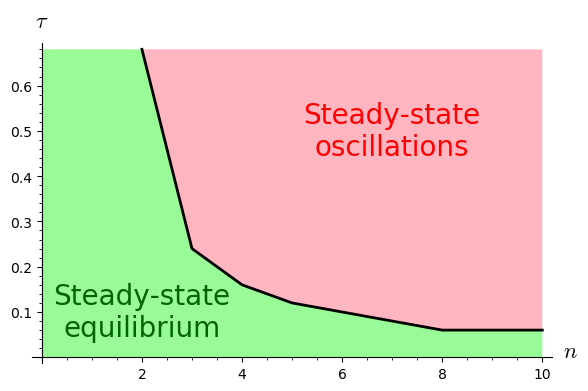

In [5]:
min_delay_for_oscillations = {
    2: 0.68,
    3: 0.24,
    4: 0.16,
    5: 0.12,
    6: 0.10,
    7: 0.08,
    8: 0.06,
    9: 0.06,
    10: 0.06,
}

xmax = max(min_delay_for_oscillations.keys())
ymax = max(min_delay_for_oscillations.values())
vertices = sorted(list(min_delay_for_oscillations.items()))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(xmax,0), (0,0), (0,ymax)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (7, 0.5), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (2, 0.1), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$", "$\\tau$"))